In [252]:
import numpy as np
import matplotlib.pyplot as plt
import math as m

In [253]:
# Define reference functions to collect data
def f1(x, t):
    y1 = 2 * np.cos(x) * np.exp(1j*t)
    return y1

def f2(x, t):
    y2 = np.sin(x) * np.exp(3j*t)
    return y2

Original data dimension: (201, 400)


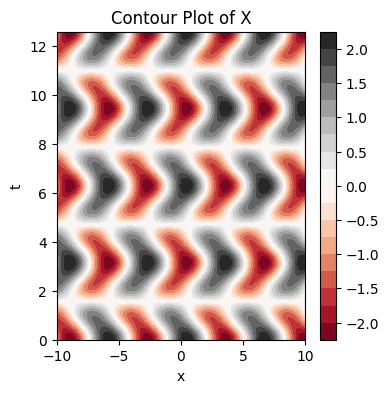

In [254]:
# Define time and space variables
xi = np.linspace(-10, 10, 400)
ti = np.linspace(0, 4*np.pi, 201)
dt = ti[1] - ti[0]
x, t = np.meshgrid(xi, ti)
X_func = f1(x, t) + f2(x, t)
print('Original data dimension:', X_func.shape)

# Plot the results of X from functions above
plt.figure(figsize=(4,4))
plt.contourf(x, t, np.real(X_func), 20, cmap='RdGy')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Contour Plot of X')
plt.show()

DMD Algorithm

In [255]:
# Create array of data generated by X_func
X = X_func.T[:, :-1]
print('Dimension of X:', X.shape)
Xprime = X_func.T[:, 1:]
print('Dimension of Xprime:', Xprime.shape)

Dimension of X: (400, 200)
Dimension of Xprime: (400, 200)


In [256]:
# STEP 1: Compute SVD of X
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)
print('SVD dimensions:', U.shape, Sigma.shape, VT.shape)


SVD dimensions: (400, 200) (200,) (200, 200)


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


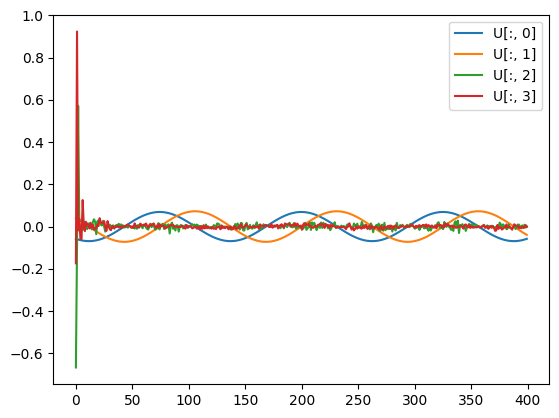

In [257]:
# Plot U
plt.plot(U[:, 0], label='U[:, 0]')
plt.plot(U[:, 1], label='U[:, 1]')
plt.plot(U[:, 2], label='U[:, 2]')
plt.plot(U[:, 3], label='U[:, 3]')
plt.legend()
plt.show()


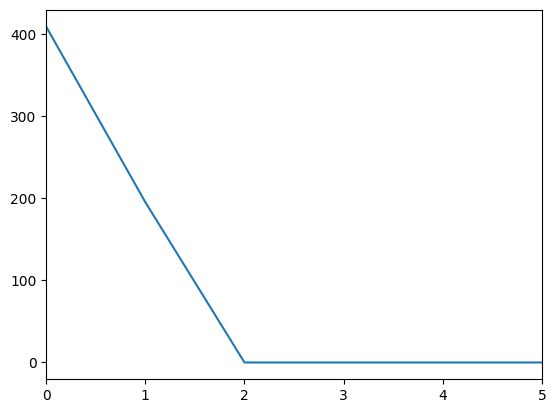

In [258]:
# Plot Sigma
plt.plot(Sigma)
plt.xlim([0,5])
plt.show()


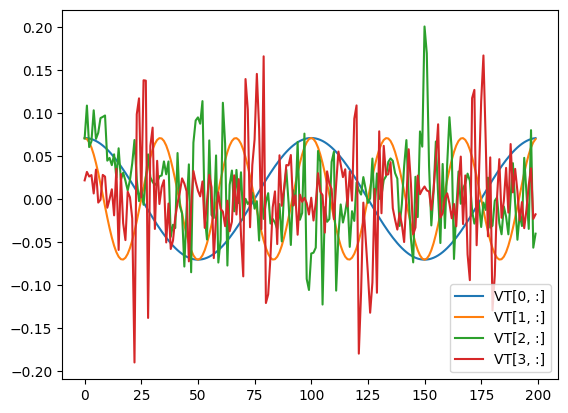

In [259]:
# Plot VT
plt.plot(VT[0, :], label='VT[0, :]')
plt.plot(VT[1, :], label='VT[1, :]')
plt.plot(VT[2, :], label='VT[2, :]')
plt.plot(VT[3, :], label='VT[3, :]')
plt.legend()
plt.show()

In [260]:
# Choose rank r = 2 to eliminate redundant data, resize U, Sigma, VT and diagonalize Sigma:
r = 2
U = U[:,:r]
Sigma = np.diag(Sigma[:r])
VT = VT[:r,:]
print('New SVD shape with rank:',U.shape, Sigma.shape, VT.shape)
print('U = ', U[:2,:2])

New SVD shape with rank: (400, 2) (2, 2) (2, 200)
U =  [[-0.05799776+7.11886290e-17j  0.03939525+1.58365802e-16j]
 [-0.05980901+2.55676730e-16j  0.03630137-5.04967735e-16j]]


In [261]:
# STEP 2: Compute A tilde which is the projection of matrix A onto POD modes in U
Atilde = U.conj().T @ Xprime @ VT.conj().T @ np.linalg.inv(Sigma)
print('Atilde = ', Atilde)

Atilde =  [[ 9.98026728e-01+6.27905195e-02j -2.32878447e-16+1.62731844e-16j]
 [-7.12324960e-17-6.29003852e-18j  9.82287251e-01+1.87381315e-01j]]


In [262]:
# STEP 3: Find the eigenvalues and eigenvector of matrix Atilde
Lambda, W = np.linalg.eig(Atilde)
print(Lambda)

[0.99802673+0.06279052j 0.98228725+0.18738131j]


Phi dimension:  (400, 2)


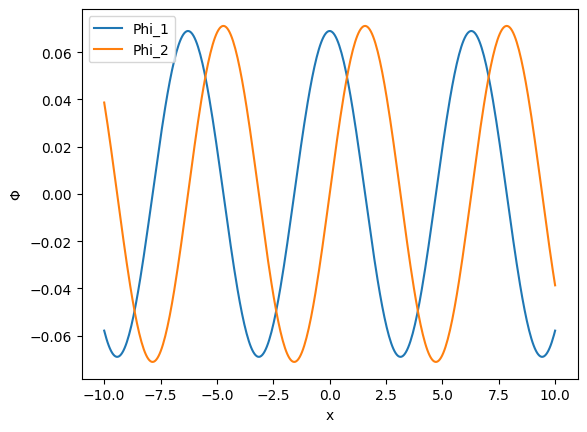

In [263]:
# STEP 4: Construct Phi the DMD modes
Phi = Xprime @ VT.conj().T @ np.linalg.inv(Sigma) @ W
print('Phi dimension: ', Phi.shape)

# Plot Phi as of POD modes
plt.plot(xi, Phi[:,0], label = 'Phi_1')
plt.plot(xi, Phi[:,1], label = 'Phi_2')
plt.xlabel('x')
plt.ylabel('$\Phi$')
plt.legend()
plt.show()

In [264]:
# Compute the amplitude vector
b = np.linalg.lstsq(Phi, X[:,0], rcond=None)[0]
b = b.reshape(b.shape[0], -1)
print('b dimension:', b.shape)
print('Amplitude vector = ', b)

b dimension: (2, 1)
Amplitude vector =  [[28.87752297-1.81681975j]
 [13.56470615-2.58760609j]]


Hypothesis to Error

b dimension: (2, 201)
(400, 201)


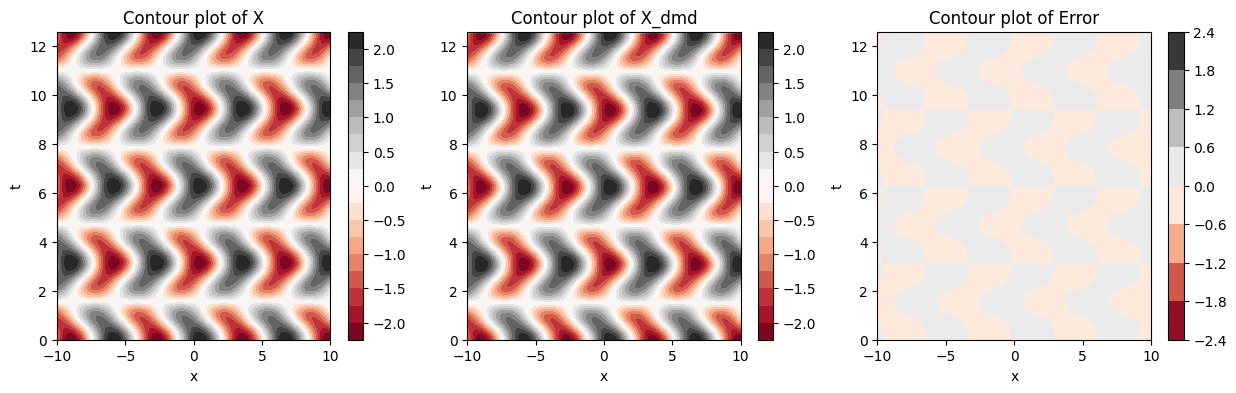

In [265]:
# Compute the amplitude vector
b_hyp = np.linalg.lstsq(Phi, X, rcond=None)[0]
b_hyp = np.hstack([b_hyp, np.zeros((2, 1))])
print('b dimension:', b_hyp.shape)

# Equation 7.30
X_hyp = Phi @ np.diag(Lambda) @ b_hyp
print(X_hyp.shape)

# Comparing results from hypothesis to original data
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.contourf(x, t, np.real(X_func), 20, cmap='RdGy')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Contour plot of X')

plt.subplot(1, 3, 2)
plt.contourf(x, t, np.real(X_hyp.T), 20, cmap='RdGy')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Contour plot of X_dmd')

diff = np.real(X_func) - np.real(X_hyp.T)
plt.subplot(1, 3, 3)
plt.contourf(x, t, diff , cmap='RdGy')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Contour plot of Error')
plt.show()


In [266]:
# Compute the continuous eigenvalues Omega
omega = np.log(Lambda)/dt
print('omega = ', omega)

omega =  [-7.06193927e-15+1.j  3.67836766e-15+3.j]


In [267]:
# Re-generate program
t_exp = np.arange(X_func.shape[0]) * dt
Omega = np.repeat(omega.reshape(-1,1), t_exp.size, axis=1)
dynamics = np.exp(Omega*t_exp) * b


In [268]:
X_DMD = Phi @ dynamics

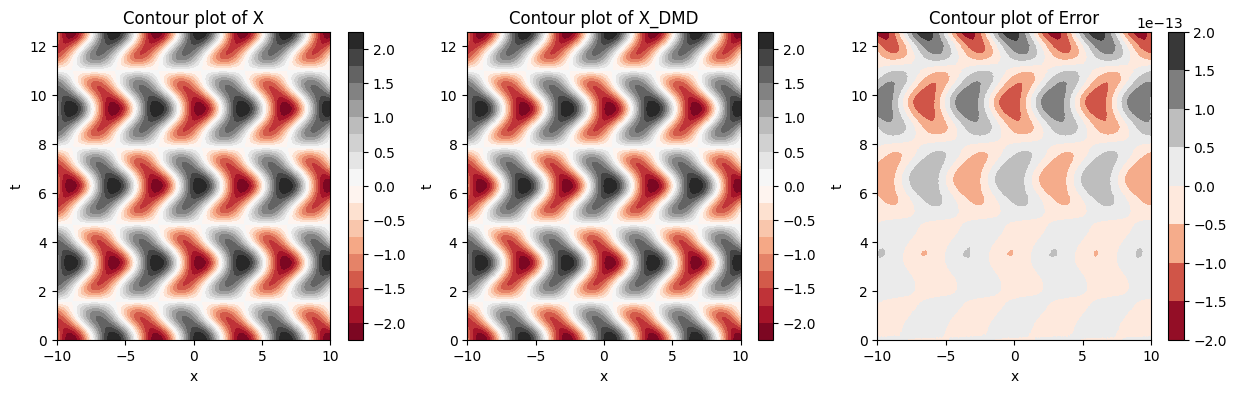

In [269]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.contourf(x, t, np.real(X_func), 20, cmap='RdGy')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Contour plot of X')

plt.subplot(1, 3, 2)
plt.contourf(x, t, np.real(X_DMD).T, 20, cmap='RdGy')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Contour plot of X_DMD')

err = np.real(X_func) - np.real(X_DMD).T
plt.subplot(1, 3, 3)
plt.contourf(x, t, err , cmap='RdGy')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Contour plot of Error')
plt.show()